In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from lightning_modules.BaseSdeGenerativeModel import BaseSdeGenerativeModel
from models.fcn import FCN
import pickle
import sde_lib

In [3]:
#log_path ='logs/ksphere/dim_10/n_1/'
#log_name = 've'
dim = 10
n_spheres = 2

log_path =f'logs/ksphere/dim_{dim}/n_{n_spheres}/'
#log_name = 've_sig_0.01_4.0'
#log_name = 've_big_sig_0.01_4.0'
log_name = 'along_axis_wide'

config_path = log_path + log_name + '/config.pkl'
with open(config_path, 'rb') as file:
    config = pickle.load(file)
#config.model.checkpoint_path = log_path  + log_name + "/checkpoints/best/last.ckpt"
config.model.checkpoint_path = 'logs/ksphere/dim_10/n_2/along_axis_wide/checkpoints/best/epoch=17550--eval_loss_epoch=35.211.ckpt'
config.logging.log_path = log_path
config.logging.log_name = log_name

config.device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [13]:
def sample(config):
    from sampling.unconditional import get_sampling_fn
    ckpt_path = config.model.checkpoint_path
    pl_module = BaseSdeGenerativeModel.load_from_checkpoint(ckpt_path)
    score_model = pl_module.score_model
    pl_module.configure_sde(config)
    pl_module = pl_module.eval()

    num_samples = 1000   
    sde = sde_lib.VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales, data_mean=None) #pl_module.sde
    sampling_eps = 1e-5
    sampling_shape = [num_samples] +  config.data.shape
    sampling_fn = get_sampling_fn(config, sde, sampling_shape, sampling_eps)
    score_model = pl_module.score_model
    samples, _ = sampling_fn(score_model)#, show_evolution=False)
    return samples

In [25]:
samples = sample(config)

100%|██████████| 1000/1000 [08:24<00:00,  1.98it/s]


In [41]:
print(torch.linalg.norm(samples, dim=1).min().item())
print(torch.linalg.norm(samples, dim=1).max().item())
print(torch.linalg.norm(samples, dim=1).mean().item())

0.9295973777770996
1.0206804275512695
0.9991390109062195


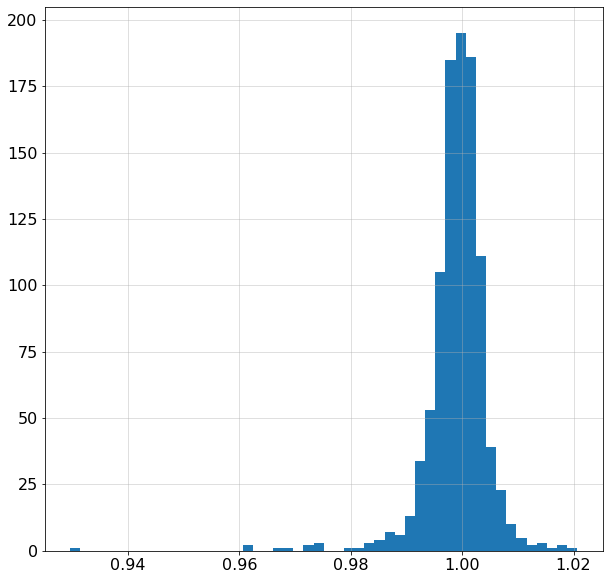

In [87]:
norms=torch.linalg.norm(samples, dim=1).numpy()
plt.figure(figsize=(10,10))
plt.grid(alpha=0.5)
plt.hist(norms, bins=50)
plt.show()

In [53]:
samples_zero = samples.clone()
samples_zero[torch.abs(samples)< 1e-3] =0
print(torch.linalg.norm(samples_zero, dim=1).mean().item())

0.9991320967674255


tensor([ 0.1452,  0.4157,  0.3839, -0.2258,  0.0649, -0.0432, -0.0954,  0.1425,
        -0.6842,  0.3355, -0.1398,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

In [14]:
from run_lib import get_manifold_dimension

In [19]:
config.data.radii = 'unit'#[1] * config.data.n_spheres
get_manifold_dimension(config)

119it [06:09,  3.11s/it]


In [20]:
path = log_path + log_name + '/svd.pkl'
with open(path, 'rb') as f:
    svd = pickle.load(f)

In [21]:
singular_values = svd['singular_values']

In [22]:
normalized_scores = svd['normalized_scores']

In [23]:
eigen_vals = (np.array(singular_values)**2).mean(axis=0)

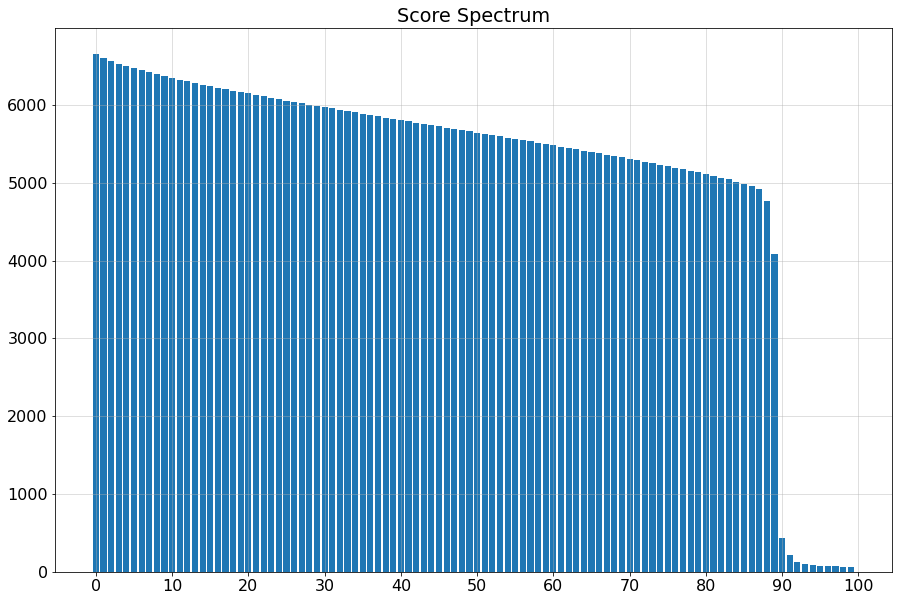

In [73]:
sing_vals = (np.array(singular_values)).mean(axis=0)
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(15,10))
plt.bar(list(range(len(sing_vals))),sing_vals)
plt.grid(alpha=0.5)
plt.title('Score Spectrum')
plt.xticks(np.arange(0, len(sing_vals)+1, 10))
plt.show()

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components='mle')
pca.fit(normalized_scores.numpy())

PCA(n_components='mle')

In [28]:
pca.n_components_

99

In [29]:
u, s, v = np.linalg.svd(normalized_scores.numpy())

<BarContainer object of 30 artists>

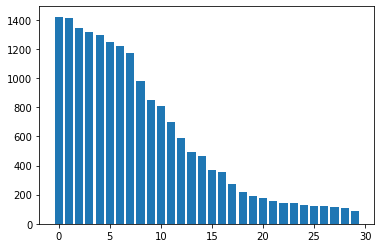

In [31]:
s=s[-30:]
plt.bar(range(len(s)),s)

In [83]:
from plot_utils import plot_spectrum

In [82]:
import importlib
import plot_utils
importlib.reload(plot_utils)

<module 'plot_utils' from '/rds/user/js2164/hpc-work/repos/score_sde_pytorch/plot_utils.py'>

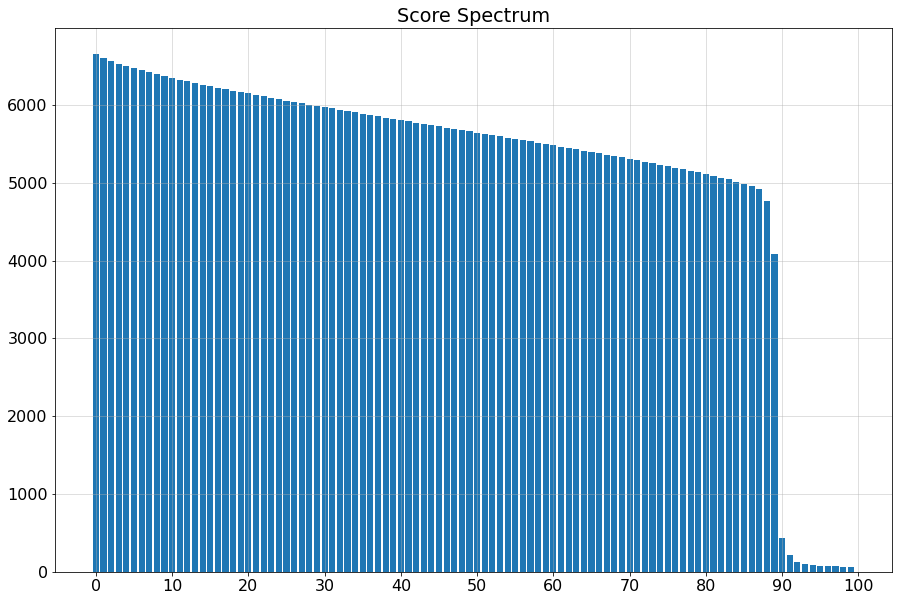

In [84]:
plot_spectrum(singular_values)

In [89]:
import uuid


'eb67b648-34cb-4d31-ac5c-b3ffbae0817c'

In [4]:
config.model

checkpoint_path: logs/ksphere/dim_10/n_2/along_axis_wide/checkpoints/best/epoch=17550--eval_loss_epoch=35.211.ckpt
dropout: 0.0
ema_rate: 0.9999
hidden_layers: 5
hidden_nodes: 2048
name: fcn
num_scales: 1000
scale_by_sigma: false
sigma_max: 4.0
sigma_min: 0.01
state_size: 100

In [5]:
config.optim

beta1: 0.9
eps: 1.0e-08
grad_clip: 1.0
lr: 2.0e-05
optimizer: Adam
warmup: 5000
weight_decay: 0